In [47]:
import re
import random
import pandas as pd
import hashlib

In [48]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")
    print(F"Total card age: {abs(existing_cards['age'].sum()):.2f}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

# if cards_to_age['age'].mean() > 80: age_factor = .5
# else: age_factor = 1

cards_to_age['age'] = cards_to_age['age'].fillna(0)
# cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.5) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1) for _ in cards_to_age.index]
if cards_to_age['age'].mean() > 80: 
    cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(1.3) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.075

cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())
cards_to_age['head_count'] = cards_to_age.groupby('head')['head'].transform("count")


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [49]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
Azure Functions + PP365,62.181815,31.090908,37.856822,2
OAuth 2.0 RFC6749,173.520595,21.690074,45.980118,8
Django,392.462059,9.811551,20.895439,40
Node.js and Vite,414.601234,10.112225,22.236207,41
pfSense,520.502241,43.375187,131.557053,12
CCH Tax Forms Project,633.731696,30.177700,97.000008,21
Accounting,706.909041,41.582885,109.502270,17
Asynchronous Python,819.444533,48.202620,89.310925,17
Python + Oauth2.0,883.633598,38.418852,109.517171,23
FSLogix,926.700458,77.225038,170.870128,12


# Histogram

sum of ages: ~45574.02


<Axes: >

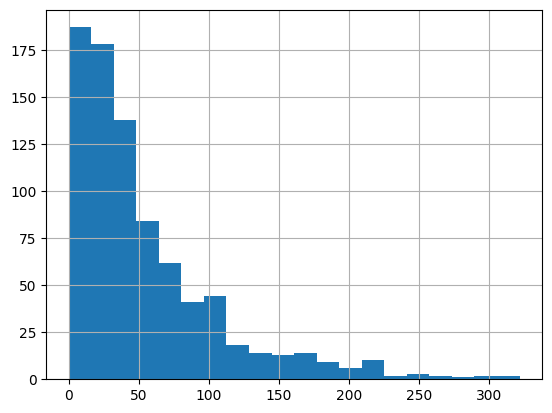

In [50]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

sum of ages: ~45574.02


<Axes: >

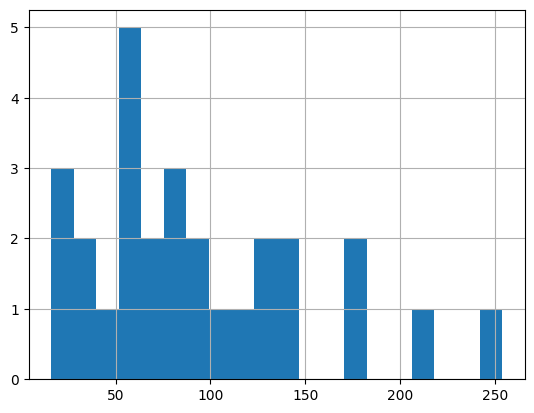

In [51]:
print(f"sum of ages: ~{existing_cards['age'].sum(0):.2f}")
existing_cards[existing_cards['head']=='Azure VM + Developer']['age'].hist(bins=20)

# Completely Random Shuffle

In [52]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [53]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# N-fold shuffle


## Age Sum

In [54]:
# n = 3
# m=existing_cards.shape[0]//100
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [55]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)

## Age Max

In [56]:
# n = 5
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'neg_age'], inplace=True)
# # existing_cards.sort_values(['age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [57]:
# n=5
# # existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['neg_age'] = existing_cards['age'] *-1
#     existing_cards['subject_highest_age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_count', 'subject_highest_age', 'neg_age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)


## Random

In [58]:
n = 3
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] % n
existing_cards['age'] *= -1
existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
remake_card_document(existing_cards=existing_cards)
existing_cards.head(10)

Cards found: 830
Total card age: 45574.02


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
3,FSLogix,Cloud Cache uses storage providers based on th...,44842f401f56251a420f6eaae9b5b151,-170.870128,77.225038,170.870128,926.700458,0.040997,12,0,0
80,FSLogix,Remote Desktop Services (RDS):\nA session-base...,a680c7dea0aa2f9c75b74b3a331d1858,-105.149137,77.225038,170.870128,926.700458,0.040997,12,3,0
154,FSLogix,Multi-Session Environment:\nA setup where mult...,07d3c049b3c42c0ac8d55b972d9fda48,-48.912519,77.225038,170.870128,926.700458,0.040997,12,6,0
226,FSLogix,When the local cache doesn't contain the data ...,29cc89097e63aa45cd021054050932e2,-26.150962,77.225038,170.870128,926.700458,0.040997,12,9,0
57,Vocab,"Something Rotten, Fforde\nPaella\nnoun | pah-A...",a37b3188a1d9c867d96671c96fbb61bf,-287.010206,89.364863,287.010206,3753.324259,0.068075,42,0,0
134,Vocab,"How to Sell a Haunted House, Hendrix\nProbate\...",ba35f791e776caa3cf598d650a402b96,-174.672585,89.364863,287.010206,3753.324259,0.068075,42,3,0
208,Vocab,"Well of Lost Plots, Fforde\nGerund\nnoun | JER...",fb000e010605cd17b1c40e7658259525,-154.858549,89.364863,287.010206,3753.324259,0.068075,42,6,0
210,Vocab,"Something Rotten, Fforde\nNacelle\nnoun | nuh-...",2ec9cfd2de25af9c0a5d0787189fc5a3,-145.291482,89.364863,287.010206,3753.324259,0.068075,42,9,0
345,Vocab,"Jingo, Pratchett\nEffendi\nnoun | eh-FEN-dee\n...",37604e4c7522fdc46ec8b705071285be,-118.186676,89.364863,287.010206,3753.324259,0.068075,42,12,0
407,Vocab,"Something Rotten, Fforde\nFlorin\nnoun | FLOR-...",ec6577b2a2dbbd383fecbf30faf61157,-99.622172,89.364863,287.010206,3753.324259,0.068075,42,15,0


In [59]:
existing_cards.head(10)['age'].sum()

np.float64(-1330.7244170232484)

In [60]:
asc = existing_cards.age.sum() < 0

existing_cards.sort_values('age', ascending=asc).head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,head_count,count,n_fold
27,TSQL,Stored Procedures:\n\nPrecompiled TSQL routine...,1c1c29f98d6c0bd8774d3c31bfcdd3e4,-321.875085,67.310049,321.875085,1615.441176,0.764174,24,0,0
9,VMWare,Host Failure\n\nWhen a physical ESXi host beco...,50554350b937a4d45efe1e2ea91d1c85,-311.941030,102.205360,311.941030,1430.875035,0.582234,14,0,0
63,Terraform Codebox,Process segmentation fault (Segmentation fault...,e4cf055569f377aaeff23124919e4d27,-303.955113,65.448802,303.955113,3206.991302,0.342433,49,0,0
45,PnP PowerShell,PSCredential (Microsoft.PowerShell.Security)\n...,58979b94f2077e07481d767d7e748fc9,-290.141121,75.726216,290.141121,2726.143759,0.321035,36,0,0
57,Vocab,"Something Rotten, Fforde\nPaella\nnoun | pah-A...",a37b3188a1d9c867d96671c96fbb61bf,-287.010206,89.364863,287.010206,3753.324259,0.068075,42,0,0
72,Python,Q:\nHow can you measure the performance of a g...,13eda1c228af6c0fae5fc403983fa80e,-261.957028,55.780931,261.957028,3960.446083,0.530140,71,0,0
33,Azure Compute Gallery,Compute Gallery Resource – The top-level conta...,cd4e5ebc6131cac516f3b36cdc1af298,-261.264478,89.133172,261.264478,2495.728808,0.475036,28,0,0
34,Azure Compute Gallery,One Compute Gallery Per Subscription – ACG is ...,7b7b4f84c6bc6891a0e1e7cf19f2922e,-256.883133,89.133172,261.264478,2495.728808,0.475036,28,1,1
42,Power BI,"Q: In a Pro workspace, which Service-side feat...",25b487580bae6b89adcd0c6909e8aa20,-256.430452,59.085341,256.430452,1949.816239,0.943895,33,0,0
36,Azure VM + Developer,.env File\nA flat file storing environment var...,5c23b6d70d4d3563ba79097e051516c5,-253.887215,92.420279,253.887215,2587.767799,0.639183,28,0,0


In [61]:
existing_cards['age'].mean()

np.float64(-54.90845418469719)